# The GeoLife set up
- load the original data set
- build as a ordered time series
- remove useless fields

In [2]:
import yaml
import pandas as pd
import pprint as pp
import glob
import os
from sys import platform

with open("conf.yaml") as f:
    conf = yaml.load(f, Loader = yaml.FullLoader)

#path to Geolife's data
geolife_data_path = conf["geolife_data_path"]
out_path = conf["out_path"]
geo_life_analysis_path = conf["geo_life_analysis_path"]
start_time = conf["start_time"]
end_time = conf["end_time"]
beijing_lat_min = conf["beijing_lat_min"]
beijing_lat_max = conf["beijing_lat_max"]
beijing_lon_min = conf["beijing_lon_min"]
beijing_lon_max = conf["beijing_lon_max"]
coverage_start_period = conf["coverage_start_period"]
coverage_end_period = conf["coverage_end_period"]

- loading all the dataset
- adding UIDs
- saving to disk after some cleaning on the data.

All the paths are local since I didn't load the dataset on uav_station's gitlab

In [ ]:
%%time

dirs = os.listdir(geolife_data_path)

#this is needed because of spotlight files created by macos
if (platform == "darwin"):
    dirs.remove(".DS_Store")

col_names = ["lat", "lon", "?", "alt", "days", "date", "time"]  

tid = 0
users = 0

#for each user (dir) we concat all its trajectories and append to df_all dataframe
"""for el in dirs:
    df = pd.concat([pd.read_csv(f, skiprows = 6, names=col_names, parse_dates=[['date', 'time']]) \
                    for f in glob.glob(path + el + "/Trajectory/*.plt")])
    df["uid"] = el
    df_all = df_all.append(df)
"""

frames = []

#for each user (dir) we concat all its trajectories and append to df_all dataframe
for el in dirs:
    print("processing",el)
    n_traj = 0
    for f in glob.glob(geolife_data_path + el + "/Trajectory/*.plt"):
        df = pd.read_csv(f, skiprows = 6, names=col_names, parse_dates=[['date', 'time']])
        df["tid"] = tid
        df["uid"] = el
        frames.append(df)
        tid += 1
        n_traj+=1
    users += 1
    print("Completion: {:.2f}, tid: {:d}".format(users/182.0, tid), end="\r")

df = pd.concat(frames)

In [ ]:
df

# GeoLife Analysis

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#helper function to plot and save figures with pyplot
def plot_df(df, x, y, name, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue', marker="o")
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid()
    plt.savefig(geo_life_analysis_path + name)
    plt.show()

#we read our previously created csv
fields = ["date_time", "lat", "lon", "uid", "tid"]
df = pd.read_csv(geolife_data_path + "geo_life_full.csv", usecols = fields, parse_dates = ["date_time"])


Now we print how many points we have for 2009

In [ ]:
#we use datetime as a mask
year = df[(df["date_time"] > start_time) & (df["date_time"] < end_time)]
print(len(year))

Now we group the number of points by week and we plot them on a linear graph

In [ ]:
#year.set_index('date_time', inplace=True)
results1 = year.groupby(pd.Grouper(freq='W')).size()
plot_df(results1, x=results1.index, y=results1, name="gps_points_weekly.png",\
       title="Number of gps points per week in a year's period" )

This time we group by month on the whole dataset

Since it looks promising, we plot the points on a weekly basis in the 12 month period between 2008-06-01 and 2009-06-1

Weekly for the whole dataset Beijin

In [ ]:
df

## Number GPS traces

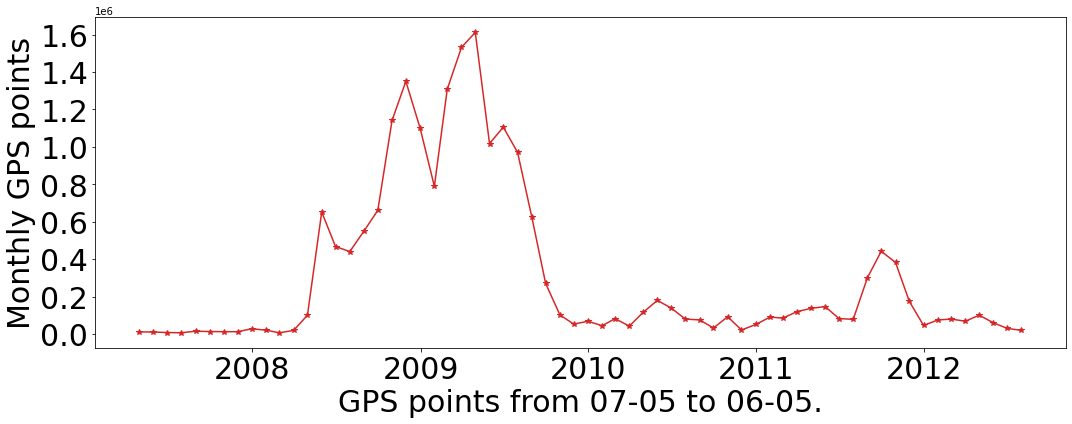

In [5]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
fontsize = 30
start_time_full = "2007-04-01 00:00:00"
end_time_full = "2012-08-31 23:59:59"

whole = df[(df["date_time"] > start_time_full) & (df["date_time"] < end_time_full)]
whole = whole[(whole['lat'].between(beijing_lat_min, beijing_lat_max)) & (whole['lon'].between(beijing_lon_min, beijing_lon_max))]


whole.set_index('date_time', inplace=True)
results2 = whole.groupby(pd.Grouper(freq='M')).size()


fig = plt.figure(figsize=(15, 6))
ax = plt.gca()
ax.plot(results2.index, results2, color='tab:red', marker="*")
plt.ylabel("Monthly GPS points",fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)

#plt.savefig(geo_life_analysis_path + name)

# inset
coverage_start_period = "2009-05-07 00:00:00"
coverage_end_period = "2009-06-05 00:00:00"
whole = df[(df["date_time"] > coverage_start_period) & (df["date_time"] < coverage_end_period)]
whole = whole[(whole['lat'].between(beijing_lat_min, beijing_lat_max)) & (whole['lon'].between(beijing_lon_min, beijing_lon_max))]
whole.set_index('date_time', inplace=True)
results2 = whole.groupby(pd.Grouper(freq='d')).size()

axins2 = inset_axes(ax, width="45%", height="35%", loc=1, borderpad = 0)
#axins2.grid()
plt.fill_between(results2.index, results2, color='tab:red', alpha = 0.8)
#plt.xticks(fontsize = fontsize-10, rotation=45)
plt.xticks([])
plt.yticks(fontsize = fontsize-10, rotation=45)


plt.xlabel("GPS points from 07-05 to 06-05.", fontsize=fontsize-10)
plt.tight_layout()
plt.savefig(geo_life_analysis_path + "GPS_points.png")



## Numbers

In [ ]:
#Statistics for the resticted period
restricted = df[(df["date_time"] > coverage_start_period) & (df["date_time"] < coverage_end_period)]
restricted = restricted[(restricted['lat'].between(beijing_lat_min, beijing_lat_max)) & (restricted['lon'].between(beijing_lon_min, beijing_lon_max))]
print("total traces:", len(restricted))
print("total users:", len(restricted["uid"].unique()))
print("total traj:", len(restricted["tid"].unique()))
print("average traj user",restricted.groupby("uid").tid.nunique().mean())

In [ ]:
restricted

## Heatmap GPS traces by day of the week

In [ ]:
# Heatmap
import seaborn as sns
restricted = df[(df["date_time"] > start_time_full) & (df["date_time"] < end_time_full)]
restricted = restricted[(restricted['lat'].between(beijing_lat_min, beijing_lat_max)) & (restricted['lon'].between(beijing_lon_min, beijing_lon_max))]


restricted['month_name'] = restricted['date_time'].dt.month;
restricted['day'] = restricted['date_time'].dt.day;


series = restricted.groupby(["month_name", "day"]).size()
df2 = series.unstack(level=-1, fill_value=0)

fig, ax = plt.subplots(figsize=(20,10))
sns.set(font_scale=2)

#ax.set_title("GPS points aggregated by day between Jan 1 2008 and Dec 31 2008")

img = sns.heatmap(df2, ax=ax, cmap="Greens",linewidths=0.2)
bottom, top = img.get_ylim()
img.set(yticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

img.set_ylim(bottom + 0.5, top - 0.5)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.set_ylabel("GPS points",fontsize=20)
ax.set_xlabel("Day",fontsize=20)

plt.savefig(os.path.join(geo_life_analysis_path, "heatmap_restricted.png"))


distinct users active in certain periods of time. We start from June 2008 and then we analyze the whole 2008 summer from June to September.

In [ ]:
#restricting to beijing area
beijing_lat_min = 39
beijing_lat_max = 41.5
beijing_lon_min = 115
beijing_lon_max = 117.5

df_t = df[(df['lat'].between(beijing_lat_min, beijing_lat_max)) & (df['lon'].between(beijing_lon_min, beijing_lon_max))]

#restricting to june 2008
start_time = "2008-06-01 00:00:00"
end_time = "2008-06-30 23:59:00"

june = df_t[(df_t.date_time > start_time) & (df_t.date_time < end_time)]

#now the whole summer
end_time = "2008-09-30 23:59:00"

summer = df_t[(df_t.date_time > start_time) & (df_t.date_time < end_time)]

Now let's see how many unique users we have for june and the whole summer.

In [ ]:
print(str(june['uid'].nunique()) + " unique users for june 2008")
print(str(summer['uid'].nunique()) + " unique user for summer 2008")


heatmap with datashader <br>
Now we restrict our coordinates to the beijing area by creating a view for the dataframe.<br>
Subsequently we copy that view to another dataframe (to avoid pandas SettingWithCopyWarning), then we delete the original df to spare some memory.

In [ ]:
#import datashader as ds
from datashader.utils import lnglat_to_meters as webm

#df_
df_t = df[(df['lat'].between(beijing_lat_min, beijing_lat_max)) & (df['lon'].between(beijing_lon_min, beijing_lon_max))]
df1 = df_t.copy(deep=True)

df1.loc[:, 'x'], df1.loc[:, 'y'] = webm(df_t.lon,df_t.lat)

del df, df_t

print(df1.head())
print(df1.info())

Now we use Datashader to print a heatmap aggregating the gps points in the Beijing Area for the whole duration of Geolife's dataset

In [ ]:
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf

plot_width = int(2000)
plot_height = int(2000)

agg = ds.Canvas(plot_width, plot_height).points(df1, 'x', 'y')
img = tf.set_background(tf.shade(agg, cmap=fire),"black")
ds.utils.export_image(img=img,filename= geo_life_analysis_path + 'beijing_dshader', fmt=".png", background="black")

Using Holoview we now produce a zoomable map of the beijing area overlayed by the gps points.

In [ ]:
import holoviews as hv
from holoviews.element.tiles import EsriImagery
from holoviews.operation.datashader import datashade
hv.extension('bokeh')

map_tiles  = EsriImagery().opts(alpha=0.5, width=1400, height=1400, bgcolor='black')
points     = hv.Points(df1, ['x', 'y'])
tracks = datashade(points, x_sampling=1, y_sampling=1, cmap=fire, width=1400, height=1400)


view = map_tiles * tracks
hv.save(view, geo_life_analysis_path + "beijing_holoview.png", fmt="auto")
view

Now we use folium to print some an heatmap of our data, once again focusing on the Beijing area.<br>
Since folium is much less optimized than datashader, we restrict our analysis to data recorded between June 1 2008 and July 1 2008, otherwise the heatmap crashes our browser.

In [ ]:
import folium 
from folium.plugins import HeatMap

#we center our map on beijing's approximate central coordinates
beijing = folium.Map(location=[39.916668, 116.383331], \
                    tiles="Stamen Terrain", zoom_start = 11)

#restricting our data a little bit (we offer a yearly view on the set already restricted for the beijing area.)
start_time = "2008-06-01 00:00:00"
end_time = "2008-06-30 23:59:00"
monthly = df1[(df1.date_time > start_time) & (df1.date_time < end_time)]

#we add all the gps points in the Beijing area to the map
HeatMap(monthly[['lat', 'lon']].values).add_to(beijing)

beijing.save(geo_life_analysis_path + "beijing_folium.html")
beijing

Now we use Seaborn to plot a couple more heatmaps about 2008 and 2009.<br>
We start with 2008.

In [ ]:
import seaborn as sns

df1['month_name'] = df1['date_time'].dt.month;
df1['day'] = df1['date_time'].dt.day;

start_time = "2008-01-01 00:00:00"
end_time = "2008-12-31 23:59:00"
year2008 = df1[(df1.date_time > start_time) & (df1.date_time < end_time)]

series = year2008.groupby(["month_name", "day"]).size()
df2 = series.unstack(level=-1, fill_value=0)

fig, ax = plt.subplots(figsize=(20,10))

ax.set_title("GPS points aggregated by day between Jan 1 2008 and Dec 31 2008")

img = sns.heatmap(df2, ax=ax, cmap="YlGnBu")
bottom, top = img.get_ylim()
img.set(yticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

img.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig(os.path.join(geo_life_analysis_path, "heatmap_2008.png"))


Now we do the same thing for 2009

In [ ]:
start_time = "2009-01-01 00:00:00"
end_time = "2009-12-31 23:59:00"
year2009 = df1[(df1.date_time > start_time) & (df1.date_time < end_time)]

series = year2009.groupby(["month_name", "day"]).size()
df3 = series.unstack(level=-1, fill_value=0)

fig, ax = plt.subplots(figsize=(20,10))

ax.set_title("GPS points aggregated by day between Jan 1 2009 and Dec 31 2009")

img = sns.heatmap(df3, ax=ax, cmap="YlGnBu")
bottom, top = img.get_ylim()
img.set(yticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

img.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig(os.path.join(geo_life_analysis_path, "heatmap_2009.png"))